In [54]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import xarray as xr
from math import sqrt
import scipy.stats as stats
from scipy import optimize
import matplotlib.colors as colors
from numpy.random import Generator, PCG64
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy import Point
from geopy.distance import distance
from geopy import units
from IPython.display import clear_output, display
import random
import pickle
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
rng = Generator(PCG64(seed=0))
#Sort the file paths to get months in order
file_paths = sorted(glob.glob("ERA5_CF_2020*.nc"))

#Check if sorted
for file_path in file_paths:
    print(file_path)
ds = xr.open_mfdataset(file_paths) #all months of 2020
print(ds)
print("----")



ERA5_CF_202001.nc
ERA5_CF_202002.nc
ERA5_CF_202003.nc
ERA5_CF_202004.nc
ERA5_CF_202005.nc
ERA5_CF_202006.nc
ERA5_CF_202007.nc
ERA5_CF_202008.nc
ERA5_CF_202009.nc
ERA5_CF_202010.nc
ERA5_CF_202011.nc
ERA5_CF_202012.nc
<xarray.Dataset>
Dimensions:     (latitude: 201, longitude: 445, time: 8784)
Coordinates:
  * longitude   (longitude) float32 -31.0 -30.75 -30.5 ... 79.5 79.75 80.0
  * latitude    (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    solarCF     (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
    windCF_off  (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
    windCF_on   (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-24 19:52:30 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    author:   

In [118]:
solards = ds.solarCF.groupby(ds.time.dt.hour).max()
#print(solards)
print()
max_solarCF = solards.max(dim='hour')
hour_of_max = solards.idxmax(dim='hour')

#Create new DataArray solards2 with max solarCF and hr values
solards2 = xr.Dataset({'max_solarCF': max_solarCF, 'hour_of_max': hour_of_max})
#print(solards2)
#print(solards2.hour_of_max)

#
ds3 = ds.solarCF.where(ds.time.dt.hour == solards2.sel(latitude=80, longitude=-31).hour_of_max,drop=True)
print(ds3)


<xarray.DataArray 'solarCF' (time: 366, latitude: 201, longitude: 445)>
dask.array<where, shape=(366, 201, 445), dtype=float32, chunksize=(31, 201, 445), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -31.0 -30.75 -30.5 -30.25 ... 79.5 79.75 80.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2020-01-01T15:00:00 ... 2020-12-31T15:00:00
Attributes:
    units:         
    short_name:   solarCF
    long_name:    Capacity factor for photovoltaics
    method:       Based on Jerez et al., 2015
    description:  Hourly capacity factor of solar panels


<h2>Handy Functions</h2>

In [9]:
#Find the (lat,lon) pair that actually exists in the dataset ds
def getActualCoords(lat, lon):
    lat_var = ds['latitude']
    lon_var = ds['longitude']

    #Get the lat,lon pair from the dataset
    actualpair = ds.sel(latitude=lat, longitude=lon,method='nearest')
    return (actualpair.latitude.values.item(), actualpair.longitude.values.item())

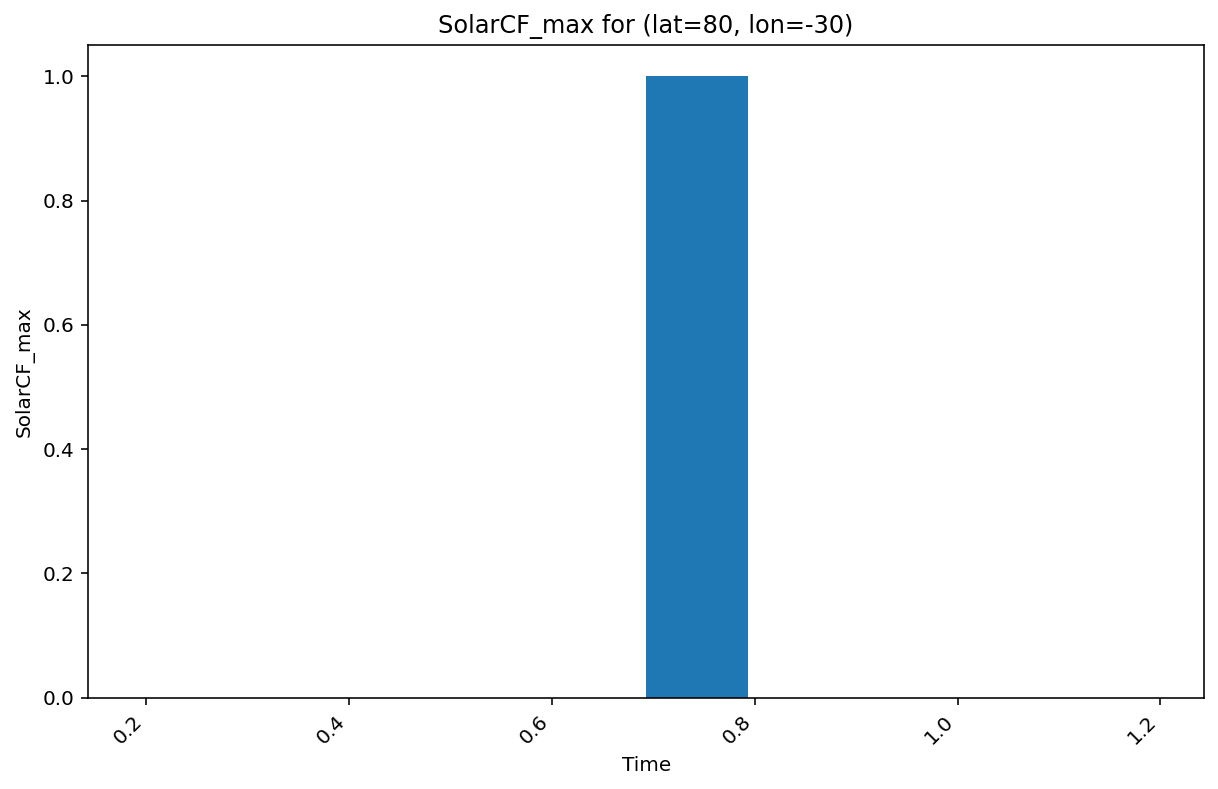

In [107]:
#Display the time series plot for a given location present in the ds
def plotCF(lat,lon):
    solar_plot = solards2.max_solarCF.sel(latitude=lat, longitude=lon)

    fig, ax = plt.subplots(figsize=(10, 6))
    solar_plot.plot(ax=ax)
    plt.xticks(rotation=45, ha='right')

    fig.patch.set_facecolor('white')
    #ax.set_xticks(range(24))
    #ax.set_xticklabels(range(24))


    ax.set_title(f'SolarCF_max for (lat={lat}, lon={lon})')
    ax.set_xlabel('Time')
    ax.set_ylabel('SolarCF_max')
    display(fig)
    plt.close(fig)

plotCF(80,-30)

In [11]:


print(solards.sel(latitude= 52.0,longitude=5.0).values)

<xarray.DataArray 'solarCF' (hour: 24, latitude: 201, longitude: 445)>
dask.array<stack, shape=(24, 201, 445), dtype=float32, chunksize=(1, 201, 445), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -31.0 -30.75 -30.5 -30.25 ... 79.5 79.75 80.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
[4.0102897e-08 3.9961275e-08 4.0206139e-08 4.0263963e-08 8.1254272e-03
 8.3143324e-02 2.2236513e-01 3.6987984e-01 5.1279193e-01 6.3346630e-01
 7.2674596e-01 7.8524780e-01 8.0906582e-01 7.7710450e-01 7.4289995e-01
 6.6530615e-01 5.3913778e-01 4.0569898e-01 2.6804021e-01 1.2954730e-01
 2.8704472e-02 4.0215976e-08 3.9984396e-08 4.0234486e-08]


In [121]:
#Get the correlation between two time series at two locations (the same location for both inputs should give correlation 1).
#make another function before sampling where you check the hour with max solarcf for your selected origin location.
def pairCorrelation(loc1, loc2): #,hours="any"

    cf1 = ds.solarCF.where(ds.time.dt.hour == solards2.sel(latitude=loc1[0], longitude=loc1[1]).hour_of_max,drop=True).sel(latitude=loc1[0], longitude=loc1[1])
    cf2 = ds.solarCF.where(ds.time.dt.hour == solards2.sel(latitude=loc1[0], longitude= loc1[1]).hour_of_max,drop=True).sel(latitude=loc2[0], longitude=loc2[1])
           

    #Calculate the correlation coefficient between the two time series, and return the relevant value from the resulting matrix
    corr_coef = np.corrcoef(cf1, cf2)[0, 1]

    return corr_coef

loc1 = (52,5)
loc2 = (45, 5)
print(pairCorrelation(loc1,loc2))


0.6452549723663622


In [65]:
#Get location at a given distance from a lat,lon coordinate.

def getLoc(lat, lon, d, angle):
    # Convert input latitude and longitude to a geopy Point object
    input_loc = Point(lat, lon)
    
    # Generate a random bearing in degrees between 0 and 360 using numpy

    
    # Calculate the destination location using geopy distance and bearing
    destination = distance(kilometers=d).destination((lat,lon), bearing=angle)
    
    # Return the latitude and longitude of the destination location
    return getActualCoords(destination.latitude, destination.longitude)



In [66]:
#function shape for fitting model.
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

In [67]:
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
times = ds['time'].values
print("Possible (lat, lon) combinations:")
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()
times_min, times_max = times.min(), times.max()

print(f"Minimum latitude: {lat_min}")
print(f"Maximum latitude: {lat_max}")
print(f"Minimum longitude: {lon_min}")
print(f"Maximum longitude: {lon_max}")

print(len(latitudes) * len(longitudes))

print(f"Minimum times: {times_min}")
print(f"Maximum times: {times_max}")

Possible (lat, lon) combinations:
Minimum latitude: 30.0
Maximum latitude: 80.0
Minimum longitude: -31.0
Maximum longitude: 80.0
89445
Minimum times: 2020-01-01T00:00:00.000000000
Maximum times: 2020-12-31T23:00:00.000000000


In [81]:
print(ds.solarCF.max().values)

1.1715465


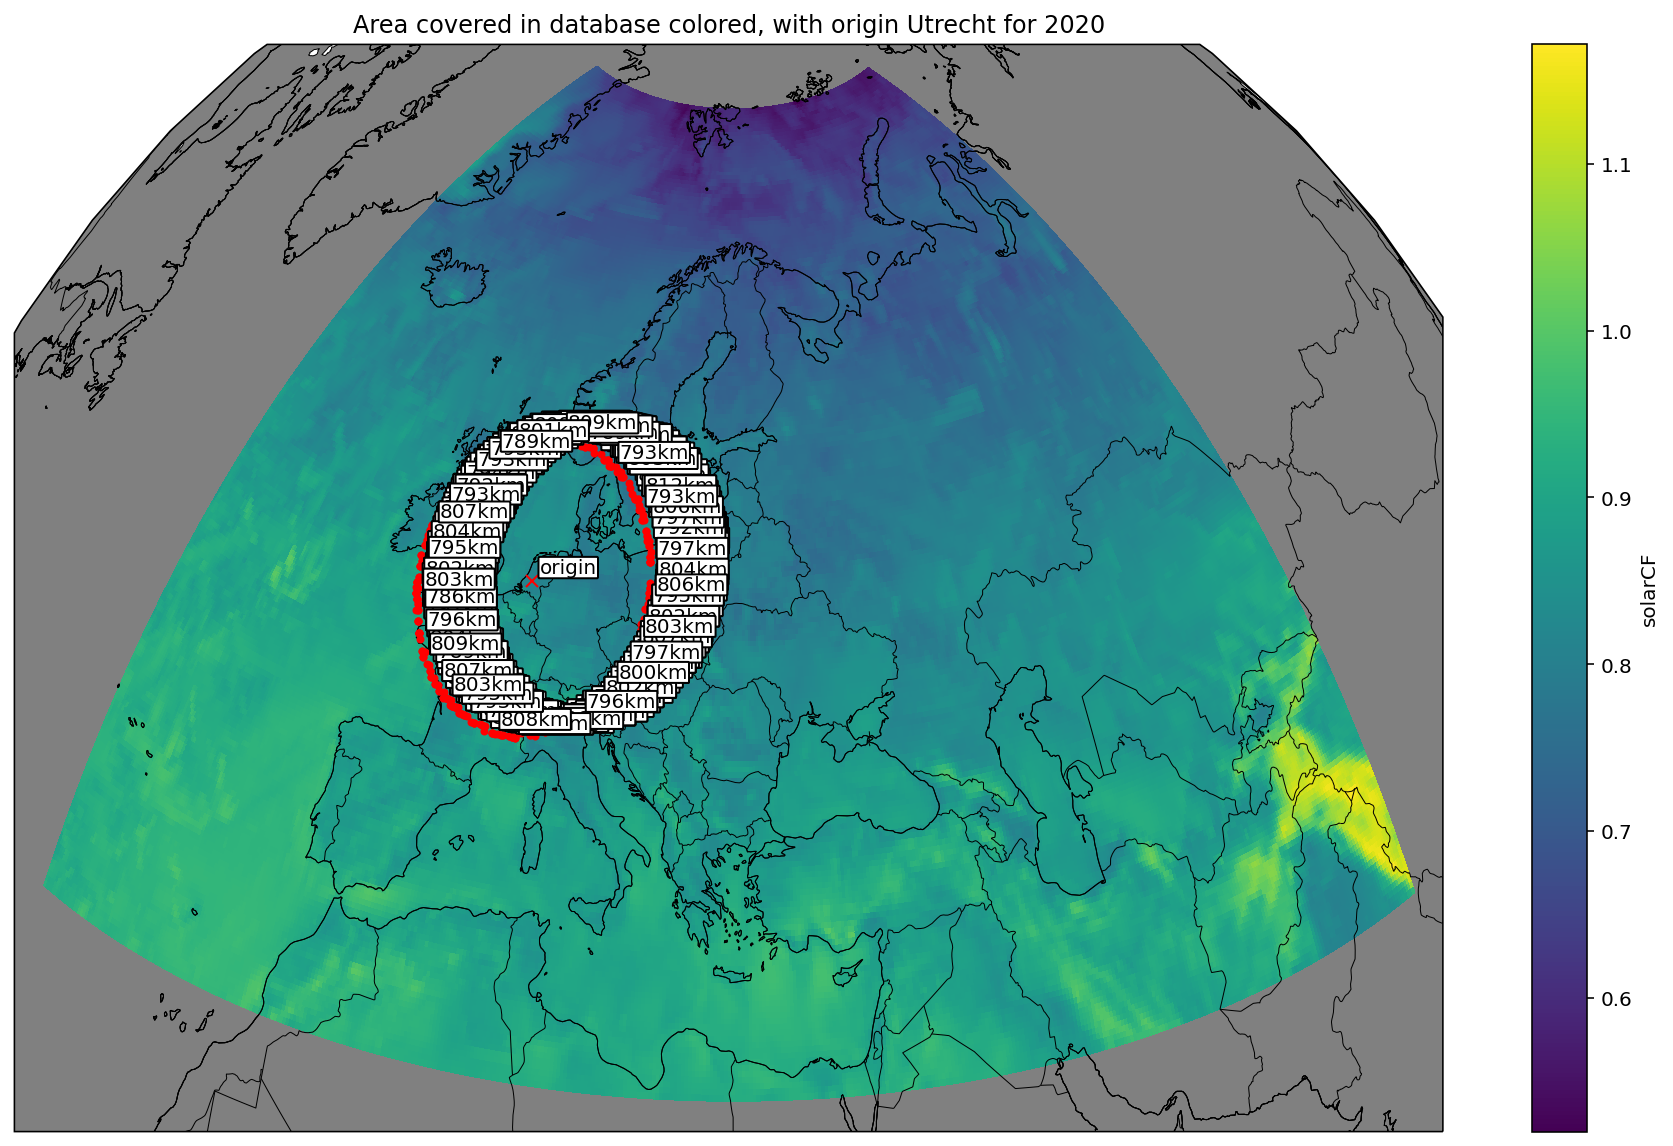

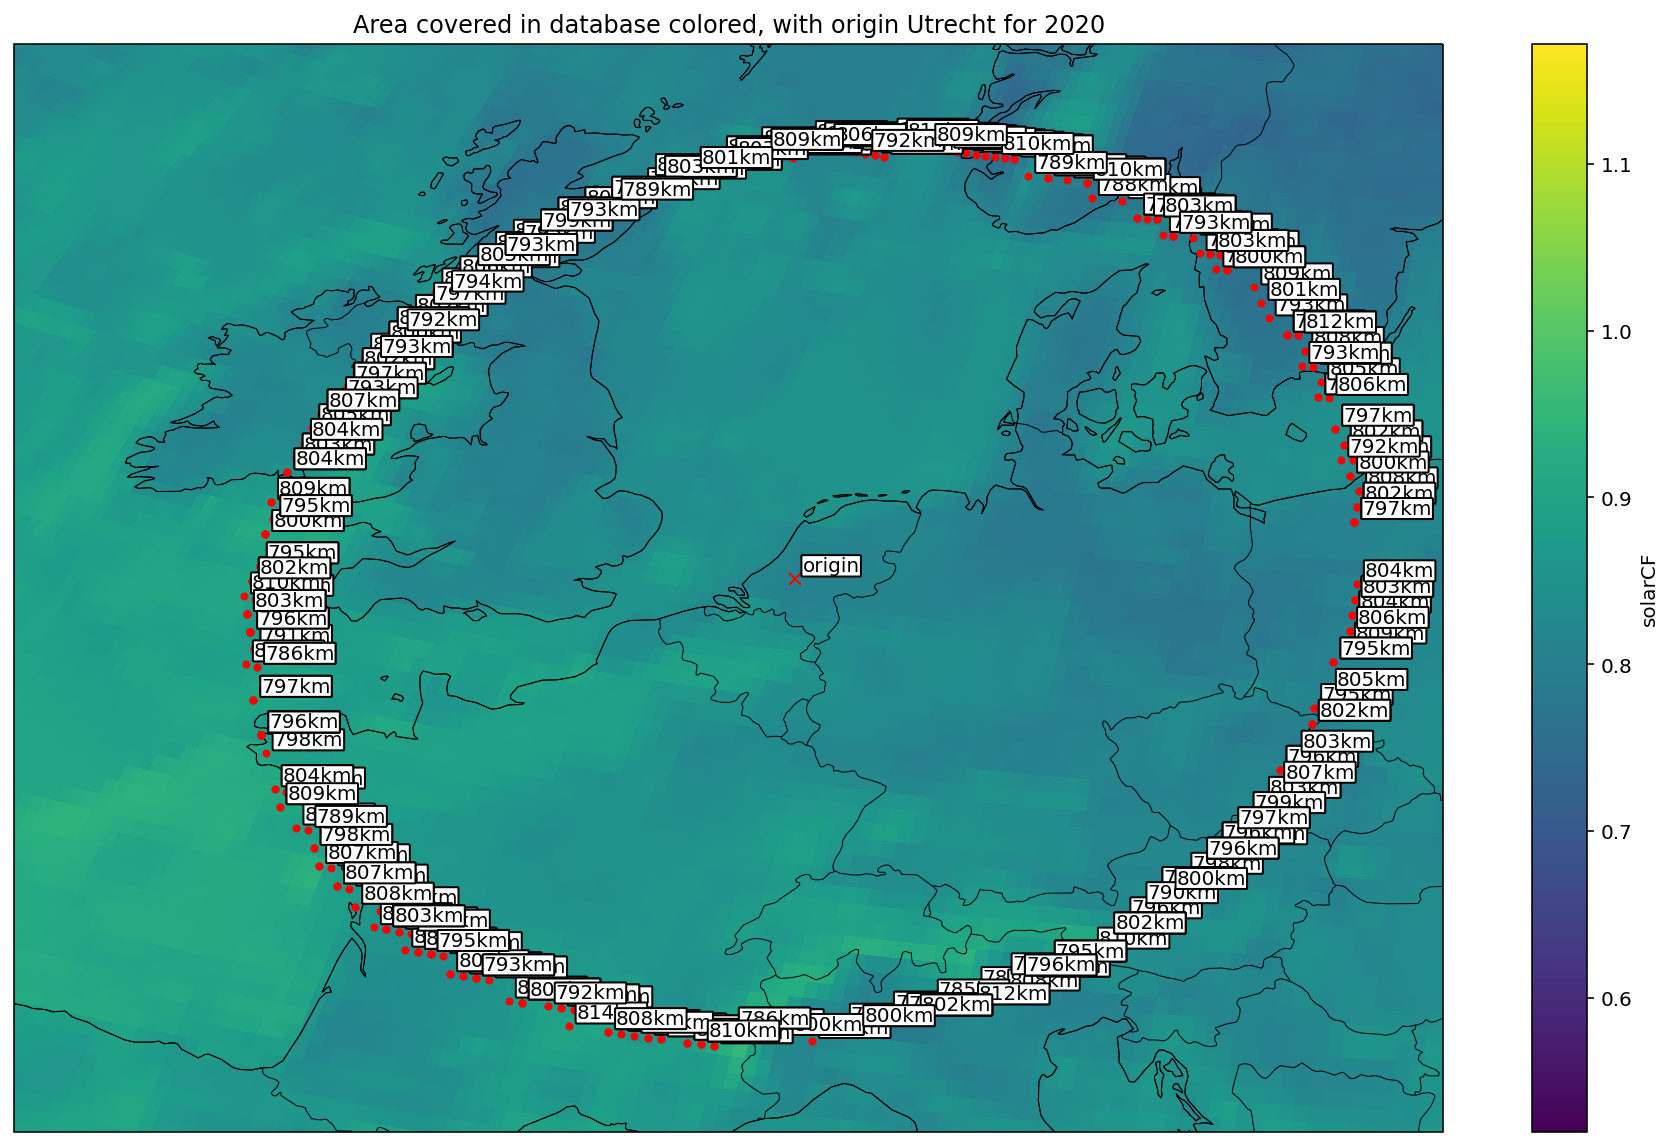

In [106]:
%matplotlib inline

#utrecht= (52.0907, 5.1214)
utrecht = (52.0,5.0)

amsterdam = (52.3676, 4.9041)
berlin = (52.5200, 13.4050)
florence = (43.7696,11.2558)
madrid = (40.4168, -3.7038)
zurich = (47.3769, 8.5417)


def rnd_dark():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    # Return the color as an RGB tuple
    return (r/255, g/255, b/255)

#lat_min +=5
#lat_max -= 5
#lon_min += 5
#lon_max -=5

edges = [(lat_min+5, lon_min+5), (lat_max-5, lon_min+5), (lat_max-5, lon_max-5), (lat_min+5, lon_max-5)]
def gridPlot(origincell,samplelist):
    centerlat = (lat_min + lat_max) / 2
    centerlon = (lon_min + lon_max) / 2

    # the coordinates of utrecht
    #lat_utrecht, lon_utrecht = 52.0907, 5.1214

    #Plot the data map
    #solarCF = ds.solarCF
    time_idx = 12



    # Calculate the max solar CF over time
    max_solarCF_vals = solards.max(dim='hour')

    

    #Plot the max solar CF
    p = max_solarCF_vals.plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(centerlat-30, centerlon), "extent": (lon_min+3, lon_max-3, lat_min-10, lat_max+3)},

    )
  

    ax = plt.gca()
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=0.5)

    ax.add_feature(cfeature.LAND.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)

    ax.set_aspect('auto', adjustable=None)
    #ax.plot(lon_utrecht, lat_utrecht, marker='x', color='red', markersize=7.5, alpha=1, transform=ccrs.PlateCarree())

    #time_string = pd.Timestamp(solarCF.time.values[time_idx]).strftime("%Y-%m-%d %H:%M:%S")
    p.axes.set_title("Area covered in database colored, with origin Utrecht for 2020")

    


    fig = plt.gcf()
    fig.set_size_inches(16, 10)
    fig.set_facecolor('white')

    return ax,fig,plt #return figure to be used in other functions

ax,fig,plt = gridPlot(utrecht,edges)
display(fig)

#Function to add markers to existing map
def addMarkers(ax,origin,lst):
    lst.append(origin)

    for i,pnt in enumerate(lst):
        if i == len(lst) - 1:
            dist_text = "origin"
            ax.plot(pnt[1], pnt[0], marker='x', color='red', markersize=6, transform=ccrs.PlateCarree())
        else:    
            dist_text = str(round(distance(utrecht,pnt).km)) + "km"
            ax.plot(pnt[1], pnt[0], marker='o', color='red', markersize=3, transform=ccrs.PlateCarree())
        ax.annotate(dist_text, xy=(pnt[1], pnt[0]), xytext=(4, 4), textcoords='offset points',transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', edgecolor='black', pad=len(dist_text)*0.01, boxstyle='round'))
    lst.pop()
        #set the extent of the axis object
        #ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

def zoom(ax, origin, lst):
    lon_pad = 0.5
    lat_pad = 0.5
    lst.append(origin)  #add it to list of markers temporarily 

    min_lon = min(lon for lat, lon in lst ) - lon_pad
    max_lon = max(lon for lat, lon in lst ) + lon_pad
    min_lat = min(lat for lat, lon in lst) - lat_pad
    max_lat = max(lat for lat, lon in lst) + lat_pad
    lst.pop() #remove origin from marker list

    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())



#Get all points around a given center
def getCirclePoints(center, distance_km):


    pointlst = []

    # Loop over bearings from 1 to 359 degrees
    for bearing in range(0, 360):
        #Calculate destination point using geopy.distance.distance() function
        destination = distance(kilometers=distance_km).destination(center, bearing)
        #Obtain actual existing coordinates in the database
        actualpoint = getActualCoords(destination.latitude,destination.longitude)
        pointlst.append((actualpoint[0], actualpoint[1]))

    # Return list of destination points
    return pointlst


#lst = getCirclePoints(utrecht,2000)

lst = []
rng = Generator(PCG64(seed=0))
for i in range(0,360):
    angle = rng.uniform(0, 360)
    lst.append(getLoc(utrecht[0],utrecht[1],800,angle))


addMarkers(ax,utrecht,lst)
display(fig)
zoom(ax,utrecht,lst)






<h2>Uncertainty Sampling for Utrecht (52,5)</h2>

In [109]:
#np.#random.seed(8)
#Holds list of values for each repetition
iterations = 1000
ValueTRUE = 400
rng = Generator(PCG64(seed=1)) #seed generator for random values

#stopping criteria
stdSC = 17 
scdiff = 3
startcount = 1
maxcount = 3

origin = (52.0,5.0) #Utrecht province
og0 = origin[0]
og1 = origin[1]


LowerBound = 100
UpperBound = 4000
locLB = getLoc(og0,og1, LowerBound,rng.uniform(0, 360))
locUB = getLoc(og0,og1,UpperBound,rng.uniform(0, 360))


rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting

Dhat_arr = []
cov_arr = []

#Time the algorithm
start_time = time.time()

rhoLB = pairCorrelation(origin,locLB) #get corr.
rhoUB = pairCorrelation(origin,locUB)

x = [LowerBound,UpperBound] #add distances from origin point to this list
y = [rhoLB,rhoUB] #store corresponding rho values in y list
locs = [locLB,locUB]

q2 = 0.5* (LowerBound+UpperBound)
locq2 = getLoc(og0,og1, 0.5* (LowerBound+UpperBound) ,rng.uniform(0, 360))
rhoq2 = pairCorrelation(origin,locq2)

x.append(q2)
y.append(rhoq2)
locs.append(locq2)

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr.append(sqrt(covs[0][0]))

i_arr = [0]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.


for i in range(0,iterations):
        i_arr.append(i+1) #update every iteration

        sf = (1.5)
        for j in range(0,4): #take 4 points per iteration
            
            #print("scalefactor",sf)
            b =  Dhat_arr[i-1] + sf * cov_arr[i-1] #the two interval bounds
            a =  Dhat_arr[i-1] - sf * cov_arr[i-1]

            #if a is negative, take 4 random points and move to next iteration of loop to prevent NaN error
            if a < 0: 

                for k in range(0,4-j): #only take as many random points as needed
                    d = rng.uniform(LowerBound,UpperBound)
                    loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
                    #if location already sampled, regenerate location with a different angle
                    while loc_d in locs:
                        loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))

                    rhod = pairCorrelation(origin,loc_d)
                    x.append(d)
                    y.append(rhod)
                    locs.append(loc_d)
                break
                
            d = - (a*b*np.log(a/b)) / (np.log(2)*(b-a)) #get the max. distance between the curves; natural log by default for numpy
            loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
            while loc_d in locs:
                loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
            rhod = pairCorrelation(origin,loc_d)
            x.append(d)
            y.append(rhod)
            locs.append(loc_d)
            sf+= 0.5 

        
        params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
        Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
        cov_arr.append(sqrt(covs[0][0]))

         #triple s.c. -> past 10 iterations, if |Dhat - prev Dhat| < 3km for at least 3 iters, and s.d. < 17km, then stop
        if(i > 10 ):
            absdiff = abs(params[0] - Dhat_arr[-2]) #estimate difference between current and previous iteration
            if (absdiff < scdiff):
                startcount+=1
            else:
                startcount = 0

            if (startcount >= maxcount and cov_arr[-1]<stdSC): 
                print("stopping criteria reached")
                break #end the algorithm in this case

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


KeyboardInterrupt: 

In [103]:
#print(x)
print("total no. of samples for Uncertainty:",len(x))
#print(cov_arr)
#print(Dhat_arr)
correlationDistance = Dhat_arr[-1]
print("Correlation distance:",correlationDistance)

#Save samples and locations
with open('results2020utrecht_UB4000.pkl', 'wb') as f:
    pickle.dump((x, y, locs,Dhat_arr,cov_arr), f)

total no. of samples for Uncertainty: 111
Correlation distance: 457.9291537862366


Text(0.5, 0, 'Sampled distance(km)')

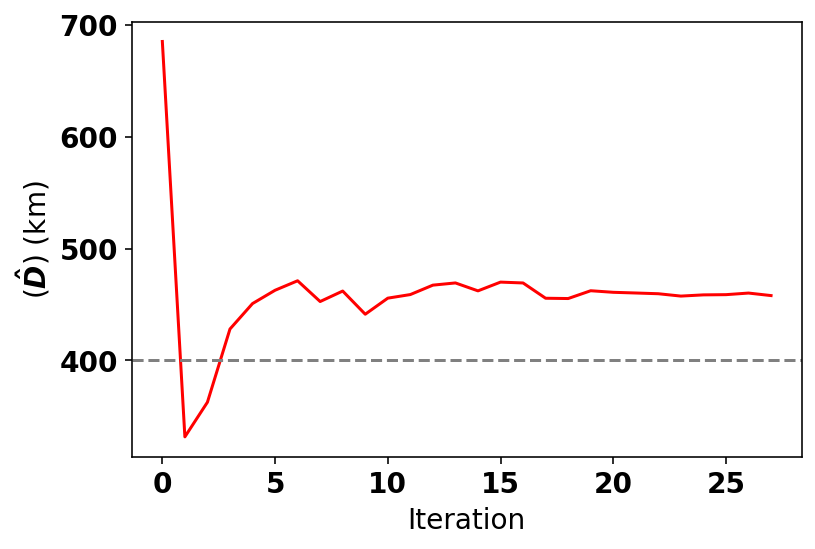

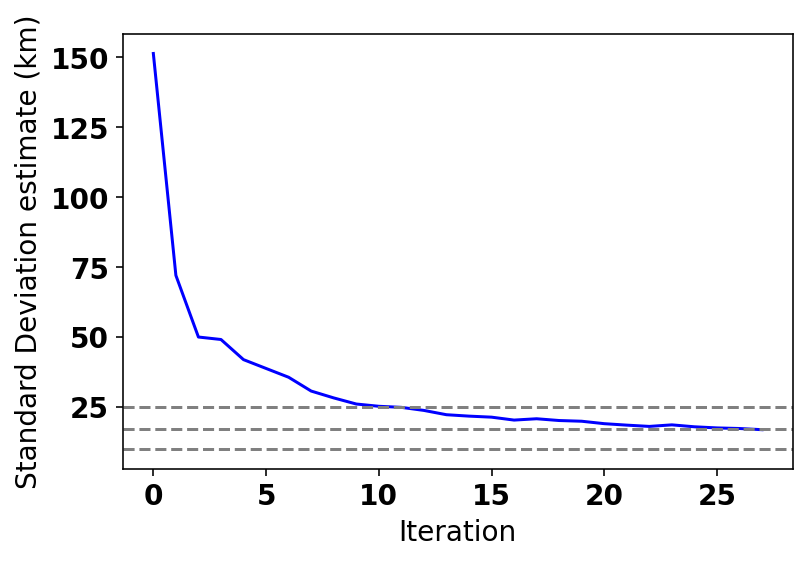

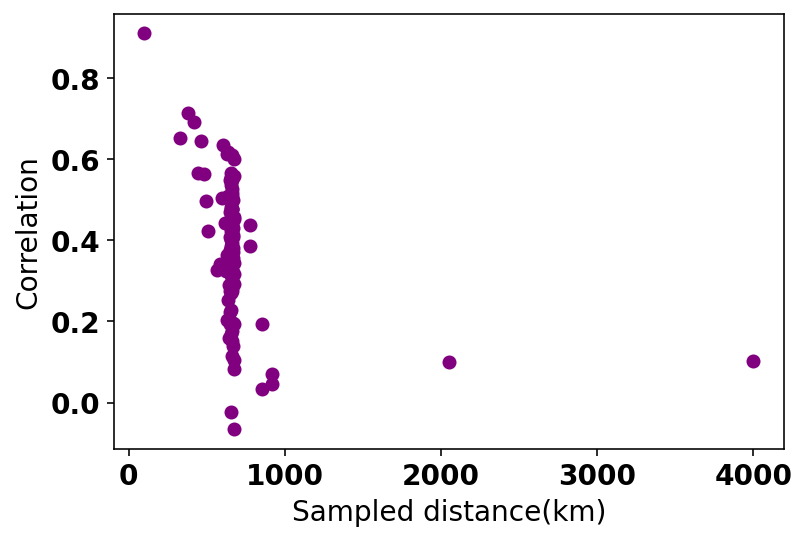

In [104]:
font = {
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

def absdiff(i):
    return (i-ValueTRUE)
#Dhat_arr_u_diff = [absdiff(i) for i in Dhat_arr] 
plt.figure(8)
plt.plot(i_arr,Dhat_arr, c='red')#,label='Uncertainty sampling' ) #systematic random
plt.axhline(y=400, color='gray', linestyle='--')
plt.ylabel('($\hat{D}$) (km)')
plt.xlabel('Iteration')  

plt.figure(9)
plt.plot(i_arr,cov_arr, c='blue')#,label='Un' ) #systematic random
plt.axhline(y=25, color='gray', linestyle='--')
plt.axhline(y=17, color='gray', linestyle='--')
plt.axhline(y=10, color='gray', linestyle='--')
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
#plt.xlim(0,100)


plt.figure(11)
plt.scatter(x,y,color='purple')#,label='U\'s Sampled Distances'
plt.ylabel('Correlation')
plt.xlabel('Sampled distance(km)')  


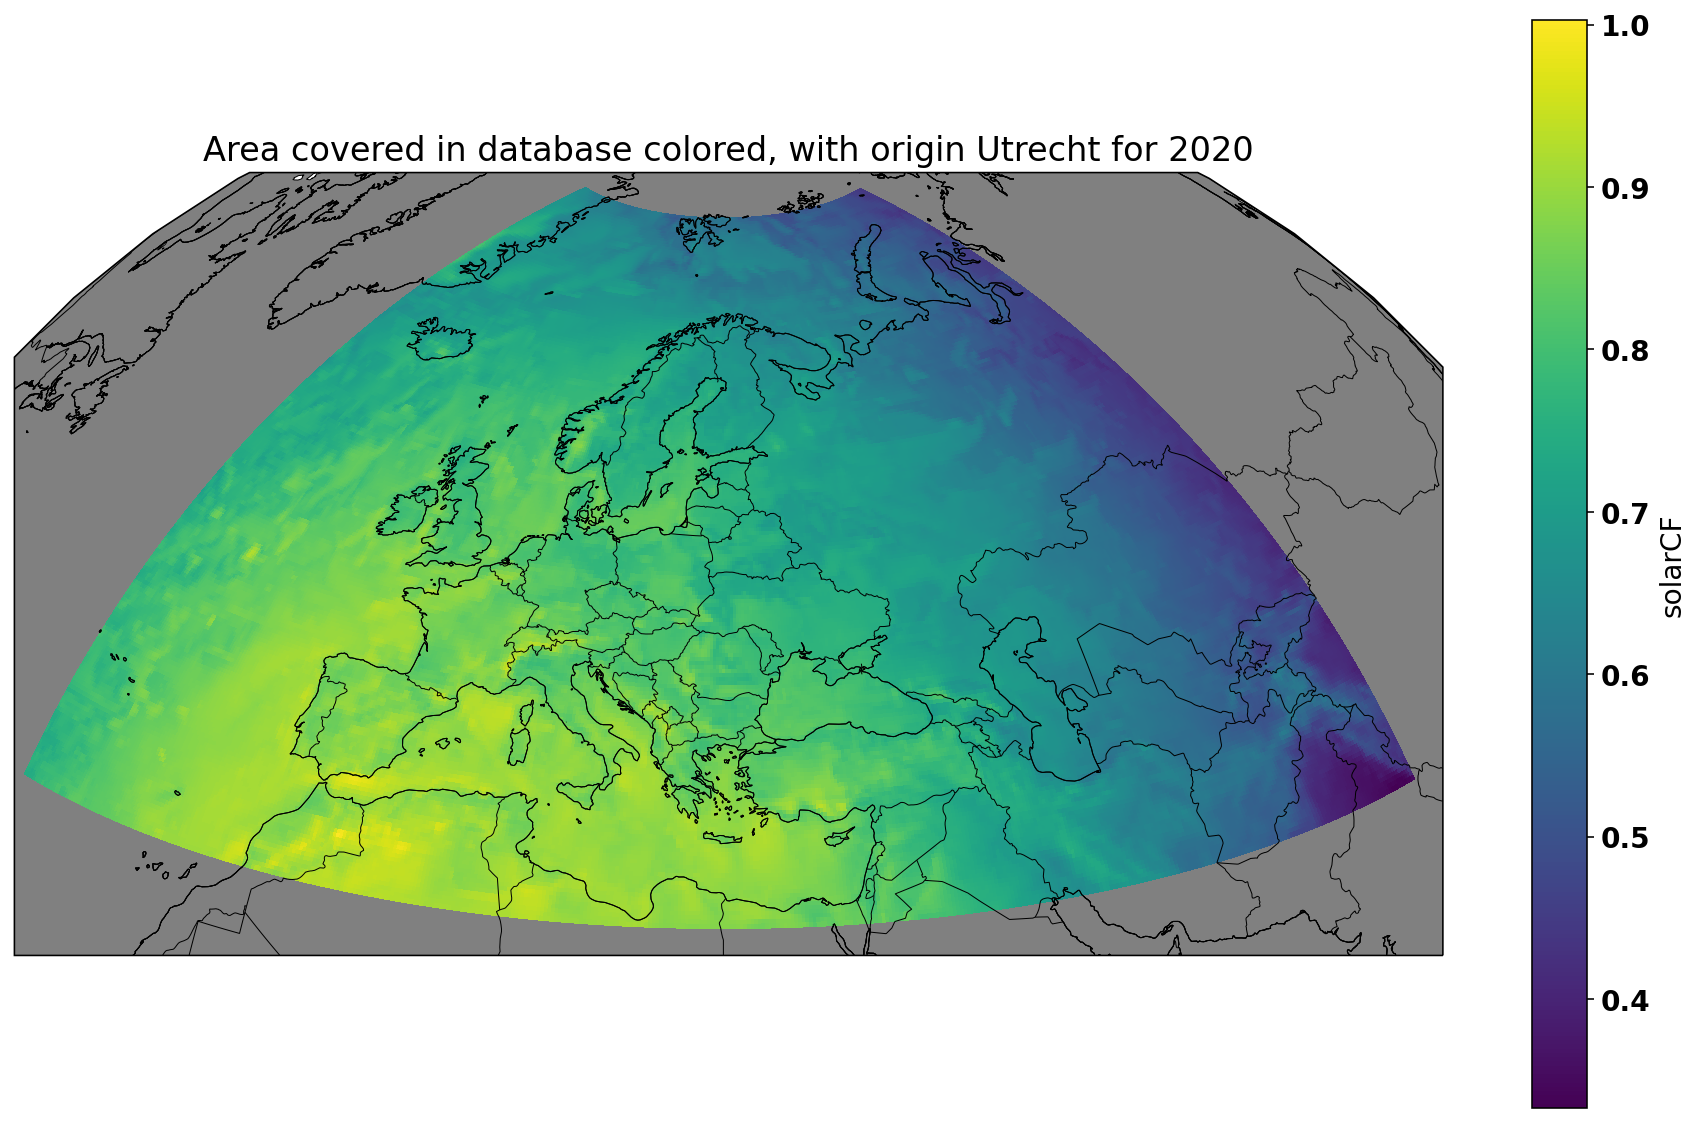

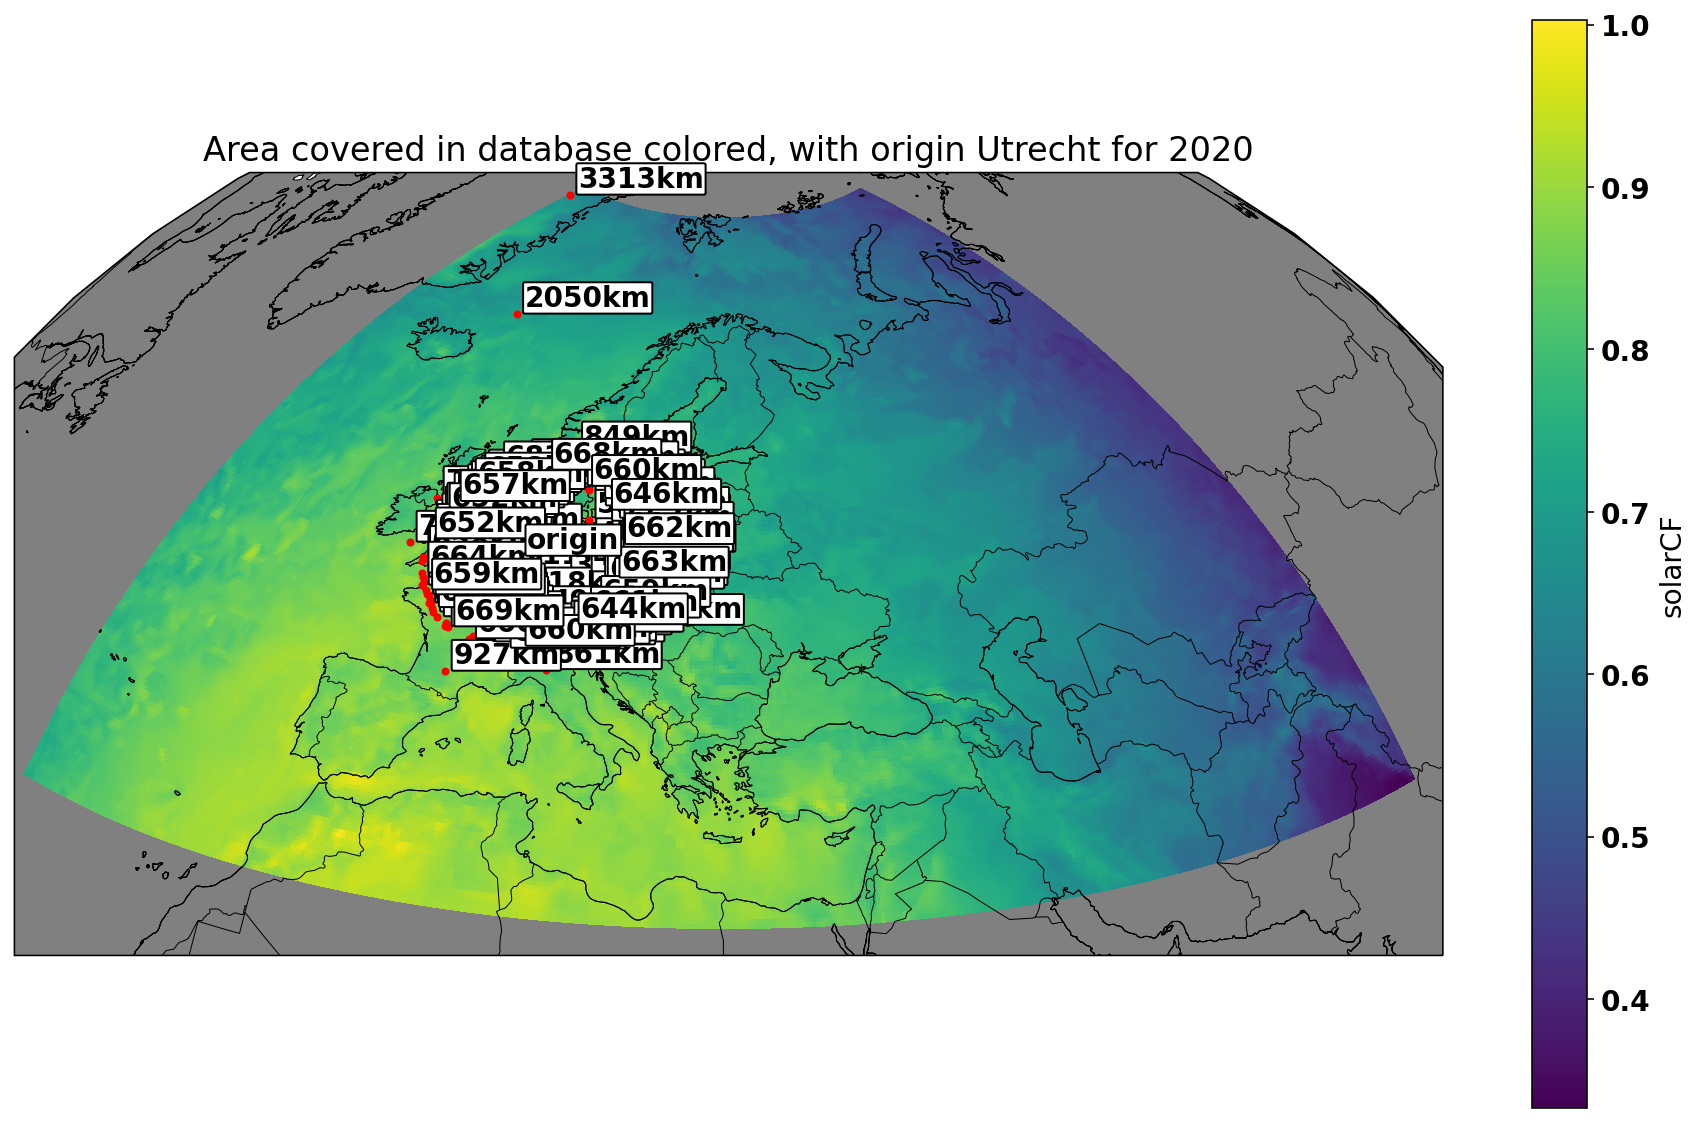

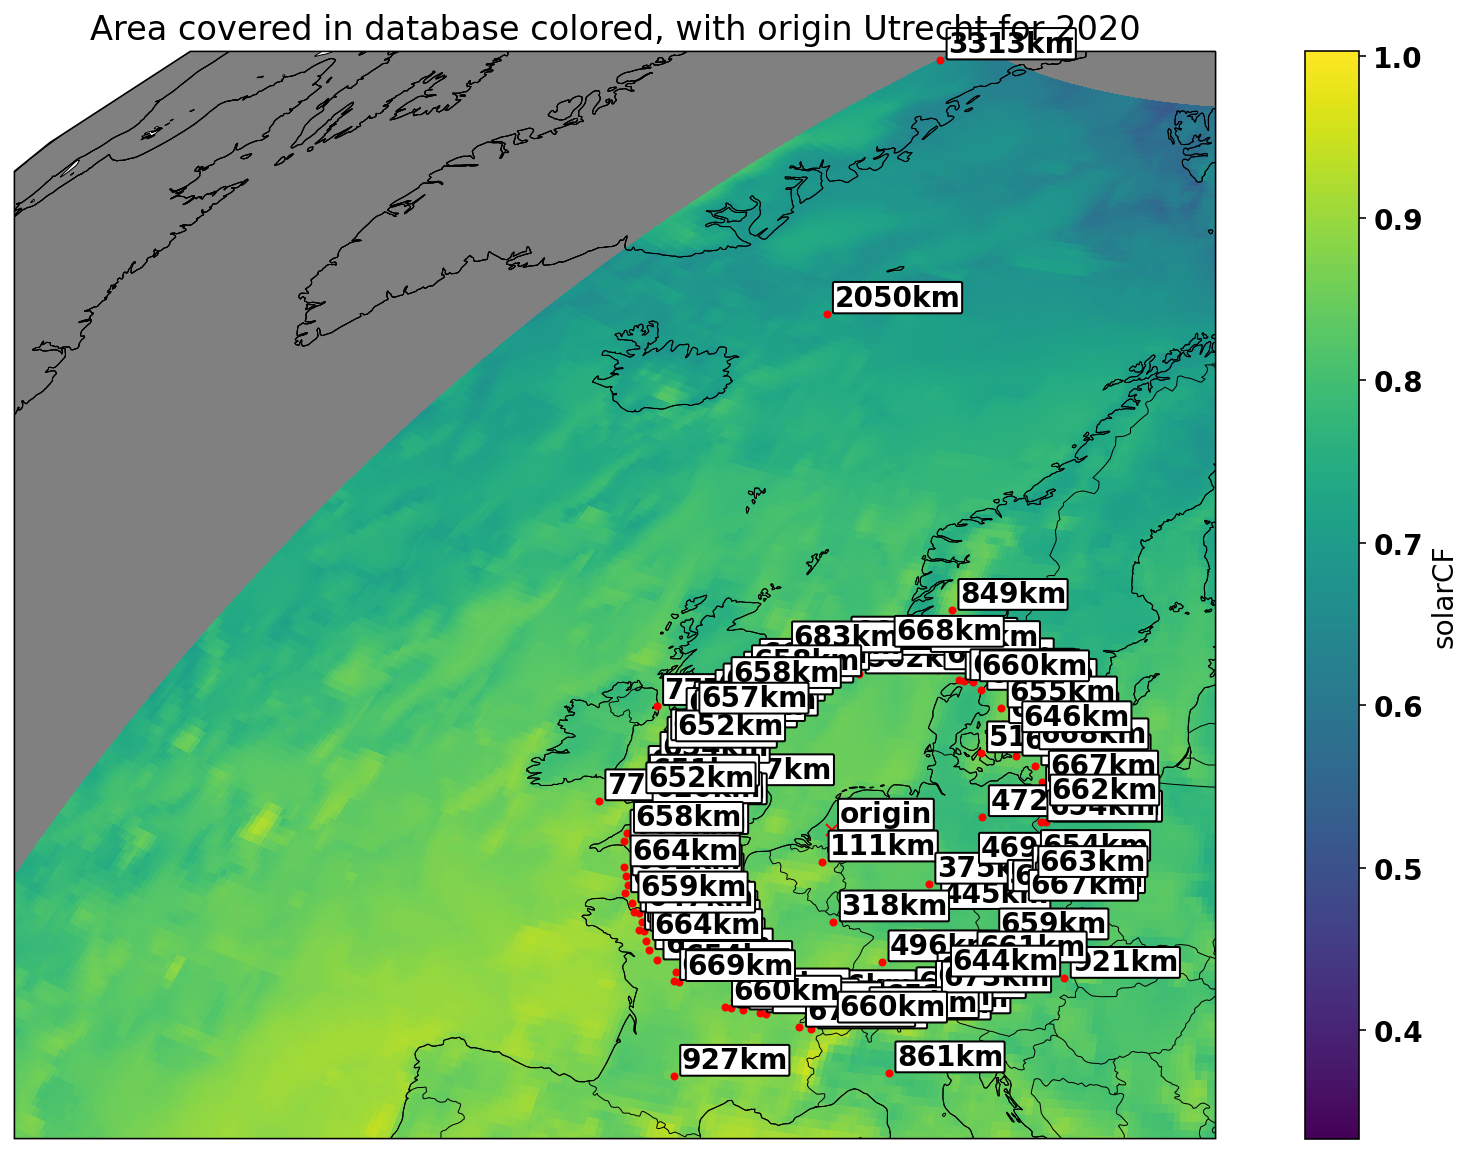

In [105]:
ax,fig,plt = gridPlot(utrecht,edges)
display(fig)

addMarkers(ax,utrecht,locs)
display(fig)
zoom(ax,utrecht,locs)

<h2>Validation</h2>

In [106]:

#Get all points at correlation distance at all whole number angles in degrees to get 360 points
allpoints =  getCirclePoints(utrecht, correlationDistance)
uniquepoints = list(set(allpoints)) #remove duplicates
corr_lst = []

for p in uniquepoints:
    corr_lst.append(pairCorrelation(utrecht,p))


In [107]:
#print(allpoints)
for coord in uniquepoints:
    dist = distance(utrecht, coord).kilometers
    print(f"Distance between {utrecht} and {coord}: {dist} km")

Distance between (52.0, 5.0) and (54.5, -0.5): 460.4163295131175 km
Distance between (52.0, 5.0) and (54.5, -0.25): 447.25018608779317 km
Distance between (52.0, 5.0) and (48.25, 7.75): 461.06554475665723 km
Distance between (52.0, 5.0) and (48.25, 7.5): 453.74430614474517 km
Distance between (52.0, 5.0) and (48.25, 7.25): 447.0167652320435 km
Distance between (52.0, 5.0) and (55.75, 8.0): 461.5684443989974 km
Distance between (52.0, 5.0) and (55.75, 8.25): 468.8139611437845 km
Distance between (52.0, 5.0) and (52.5, 11.75): 464.16067593890335 km
Distance between (52.0, 5.0) and (54.75, -0.25): 464.27491164813034 km
Distance between (52.0, 5.0) and (54.75, 0.0): 451.9120762826703 km
Distance between (52.0, 5.0) and (56.0, 3.0): 464.08315410058776 km
Distance between (52.0, 5.0) and (56.0, 3.25): 459.731650285544 km
Distance between (52.0, 5.0) and (56.0, 3.5): 455.92664213192137 km
Distance between (52.0, 5.0) and (56.0, 3.75): 452.6819585428428 km
Distance between (52.0, 5.0) and (50.

plot distances w/ correlation and also record spread between found locations and actual locations.

if  std dev in alg is in the same order in st dev in the samples taken at that distance.

output of fitted model would be residuals 

In [109]:

print(f"Mean correlation at correlation distance {correlationDistance: .1f}km : ",np.mean(corr_lst))

Mean correlation at correlation distance  457.9km :  0.5453339163212197


one point per distance in a random direction.

to evaluate -> check correlation at CD given by model. take lat,lon by taking every  degree in a "circle", making sure each coord is taken only once.

for map, plot avg (mean) values of solar (or wind) cf.

for solar mean, do groupby of the hour of the day (eg only take timestamps that are 12pm)

always take 4 sample grid cells. if you have a given sample distance, 

In [110]:
from collections import Counter

def print_duplicates(lst):
    counter = Counter(lst)
    duplicates = {value: count for value, count in counter.items() if count > 1}
    for value, count in duplicates.items():
        print(f"Value: {value}, Count: {count}")

print_duplicates(uniquepoints)